In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Library/CloudStorage/Box-Box/Research/discrete_sr/code/SPIDER_discrete/src')

In [2]:
import numpy as np

from PySPIDER.commons.weight import *
from PySPIDER.commons.utils import save, load
from PySPIDER.discrete.library import *
from PySPIDER.discrete.process_library_terms import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
#positions, vs, deltat, dims = load('Matt/sim_n64_v03.npy', 4)
#positions, vs, deltat, dims = load('Matt/sim_n1024.npy', 4)
#positions, vs, deltat, dims = load('Matt/sim_n1024_default_v2.npy', 4)
positions, vs, deltat, dims = load('Matt/sim_n10000.npy', 4)

#Lsf = 100 # length scaling factor - to nondimensionalize rho
#Tsf = 0.01 # time scaling factor - to keep v~O(1)
#positions *= Lsf
#vs *= (Lsf*Tsf)
#deltat /= Tsf
#dims[:-1] *= Lsf

print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

(10000, 2, 512) (10000, 2, 512) 0.00125 [  1 512]
[  1   1 512]


In [4]:
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

# vid_file = 'Matt/sim_n10000.mp4'

# fig, ax = plt.subplots(figsize=(6, 6))
# qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

# def animate(i):
#     if i % 10 == 0:
#         print(i)
#     qv.set_offsets(positions[:, :, i])
#     norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
#     qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
#     return qv,

# anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
# FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
# anim.save(vid_file, writer=FFwriter, dpi=100)

In [ ]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 0.02 #0.2
#corr_T = 0.01 #0.1
kernel_sigma = 0.02 # 0.05
time_sigma = 0 #4
cg_res = 256
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, rho_scale=Np,
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6, wrap=True)
                #time_sigma=time_sigma) # !!!
v_est = np.mean(np.abs(vs))*2**0.5
print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_rho=2)
srd.make_libraries(max_complexity=5, max_rho=2)
#srd.make_libraries(max_complexity=6, max_rho=2)
for irrep in srd.irreps:
    print(irrep, ":", len(srd.libs[irrep].terms))

dom_width = 0.1 # 0.3
dom_time = 40
#srd.make_domains(ndomains=10, domain_size=[dom_width, dom_width, dom_time])
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time])
#srd.make_domains(ndomains=100, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
srd.make_weights(m=8, qmax=1)
srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
#srd.set_LT_scale(L=corr_L, T=corr_T) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_gauss1024.npy', srd)

0.8486350690926066
Rank 0 : 42
Rank 1 : 50
Antisymmetric rank 2 : 14
Symmetric trace-free rank 2 : 34


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:

np.save('Qs.npy', {irrep: lib.Q for irrep, lib in srd.libs.items()})

In [ ]:
from scipy.stats._stats import gaussian_kernel_estimate
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

def coarse_grain_slice(t, sigma, field='rho', component=None):
    pt_pos = positions[:, :, t]
    weights = np.ones(pt_pos.shape[0], dtype=np.float64)
    if field == 'v':
        weights *= vs[:, component, t]
    xx, yy = np.meshgrid(np.linspace(0, 1, cg_res), np.linspace(0, 1, cg_res))
    xi = np.vstack([xx.ravel(), yy.ravel()]).T

    sigma_sq = sigma ** 2
    # Check scipy version. If it's lower than 1.10, use inverse_covariance, otherwise use Cholesky
    if int(scipy.__version__.split(".")[0]) <= 1 and int(scipy.__version__.split(".")[1]) < 10:
        inv_cov = np.eye(2) / sigma_sq
    else:
        inv_cov = np.eye(2) * sigma_sq
        inv_cov = np.linalg.cholesky(inv_cov[::-1, ::-1]).T[::-1, ::-1]
    density = gaussian_kernel_estimate['double'](pt_pos, weights[:, None], xi, inv_cov,
                                                 np.float64)
    output = np.reshape(density[:, 0], xx.shape) / 1e4
    return output

t = 100
sigma = 0.05
rho_cg = coarse_grain_slice(t, sigma, field='rho')
vx_cg = coarse_grain_slice(t, sigma, field='v', component=0)
vy_cg = coarse_grain_slice(t, sigma, field='v', component=1)

In [ ]:
# fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
# im1 = ax1.imshow(rho_cg)

# frame = plt.gca()
# frame.axes.get_xaxis().set_visible(False)
# frame.axes.get_yaxis().set_visible(False)
# #colorbar
# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cb1 = plt.colorbar(im1, cax=cax1)
# cb1.ax.tick_params(labelsize=24) 

# name = f'cg_rho_{sigma}.eps'
# plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

In [ ]:
# fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
# im1 = ax1.imshow(vx_cg)

# frame = plt.gca()
# frame.axes.get_xaxis().set_visible(False)
# frame.axes.get_yaxis().set_visible(False)
# #colorbar
# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cb1 = plt.colorbar(im1, cax=cax1)
# cb1.ax.tick_params(labelsize=24) 

# name = f'cg_vx_{sigma}.eps'
# plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

In [ ]:
from PySPIDER.commons.identify_models import *
from PySPIDER.commons.sparse_reg_bf import *

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
    #init = Initializer(method='combinatorial', start_k=3)
    init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    #res = Residual(residual_type='dominant_balance')
    res = Residual(residual_type='matrix_relative')
    #res = Residual(residual_type='hybrid')
    
    #iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
    iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)


eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
    reg_opts_list, threshold=2.5e-3, experimental=True, report_accuracy=True,
    #reg_opts_list, threshold=6e-2, experimental=True,
    #print_opts={'num_format': '{0:.3g}', 'latex_output': True}
)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.01 s]
Identified model: ∂t ρ + 1 · ∂α ρ[v_α] = 0 (order 3, residual 7.14e-07)
(r_h = 1.46e-06)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 4 ---
[0.0

[3.098e-01 7.137e-07 7.005e-07 6.988e-07 6.982e-07 6.981e-07 6.975e-07
 6.972e-07]
(np.float64(1.0), np.float64(0.9999998996911552))
[ρ · ∂t ρ, ∂α² ρ, ∂t ρ, ∂t² ρ, ∂α ρ[v_α]]
∂t ρ + 1 · ∂α ρ[v_α] = 0


/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_1998/3217646527.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


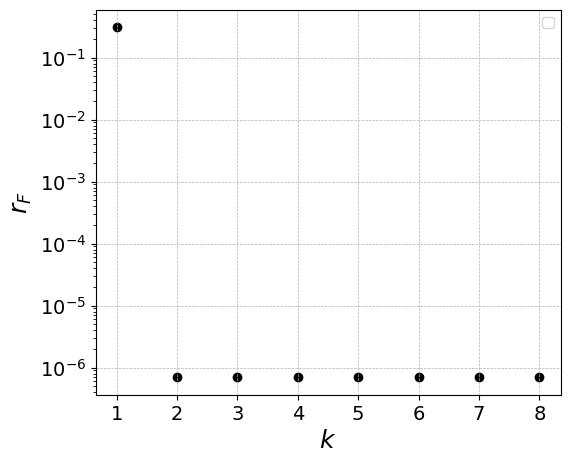

[0.038 0.003 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001]
(np.float64(1.0), np.float64(-0.20070270485656155), np.float64(-0.9742565976393199), np.float64(0.19319893571316357))
[ρ · ρ, ρ · ∂α² ρ, ρ · ∂t² ρ, ∂α² ρ, ∂t² ρ]
ρ · ∂α² ρ + -0.201 · ρ · ∂t² ρ + -0.974 · ∂α² ρ + 0.193 · ∂t² ρ = 0


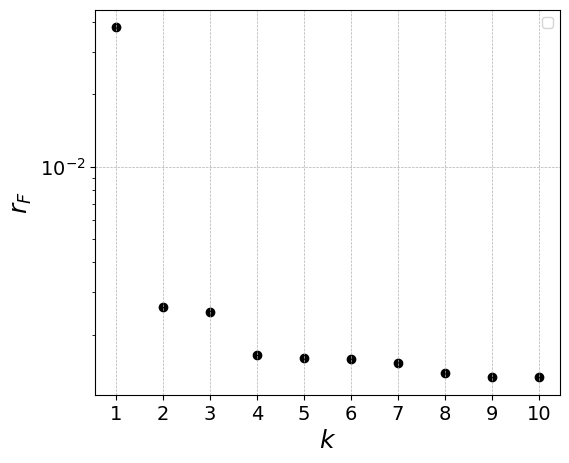

[0.043 0.004 0.004 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002]
(np.float64(-0.998022021569808), np.float64(1.0), np.float64(-0.7343597731000894), np.float64(0.7220254987366547))
[ρ, ρ · ρ, ρ · ∂t² ρ, ρ · ρ[v_α · v_α], ρ[v_α · v_α]]
-0.998 · ρ + ρ · ρ + -0.734 · ρ · ρ[v_α · v_α] + 0.722 · ρ[v_α · v_α] = 0


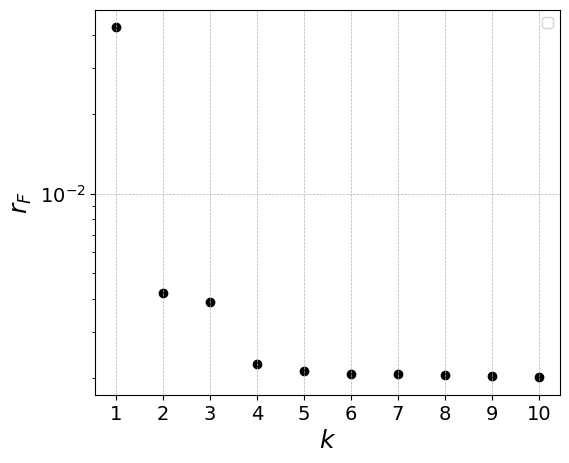

[0.038 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002]
(np.float64(1.0), np.float64(0.183388843393154), np.float64(-0.9908632703237754), np.float64(-0.18174277829087837))
[ρ · ∂α ρ, ρ · ∂t ρ[v_α], ∂α ρ, ∂t² ∂α ρ, ∂t ρ[v_α]]
ρ · ∂α ρ + 0.183 · ρ · ∂t ρ[v_α] + -0.991 · ∂α ρ + -0.182 · ∂t ρ[v_α] = 0


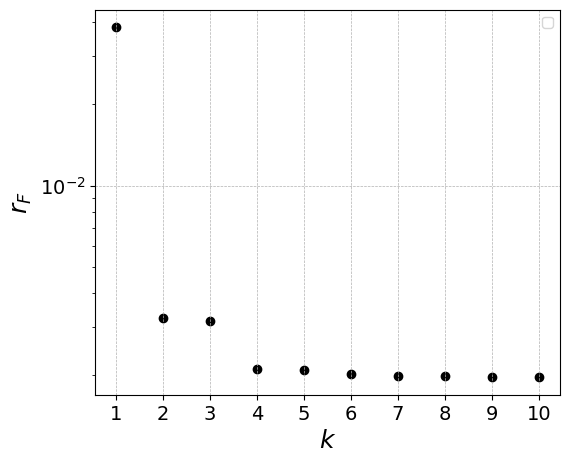

[0.014 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
(np.float64(1.0), np.float64(-0.9772801617943361))
[ρ, ρ · ρ, ∂t ∂α ρ · ρ[v_α], ∂t² ρ, ∂α ∂β ρ[v_α · v_β]]
ρ + -0.977 · ρ · ρ = 0


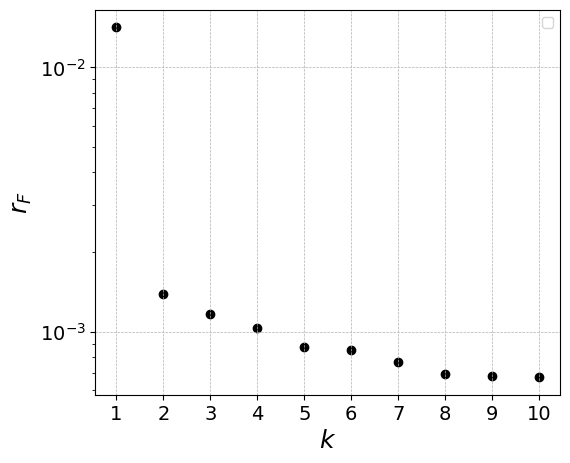

[0.013 0.008 0.003 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001]
(np.float64(1.0), np.float64(3.405820339907106e-05), np.float64(-0.16109393066719066), np.float64(0.16879058142644968))
[∂α ρ · ∂α ρ, ∂α² ρ, ∂α² ∂β² ρ, ∂t² ρ, ∂α ∂β ρ[v_α · v_β]]
∂α² ρ + 3.41e-05 · ∂α² ∂β² ρ + -0.161 · ∂t² ρ + 0.169 · ∂α ∂β ρ[v_α · v_β] = 0


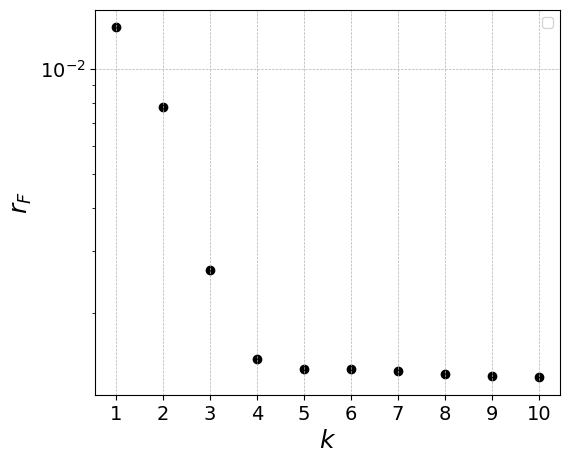

[0.018 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001]
(np.float64(1.0), np.float64(-0.5798585414606382), np.float64(-0.9638425097497478), np.float64(0.5522203703083872))
[ρ · ρ[v_α], ρ · ρ[v_α · v_β · v_β], ∂β² ρ · ρ[v_α], ρ[v_α], ρ[v_α · v_β · v_β]]
ρ · ρ[v_α] + -0.58 · ρ · ρ[v_α · v_β · v_β] + -0.964 · ρ[v_α] + 0.552 · ρ[v_α · v_β · v_β] = 0


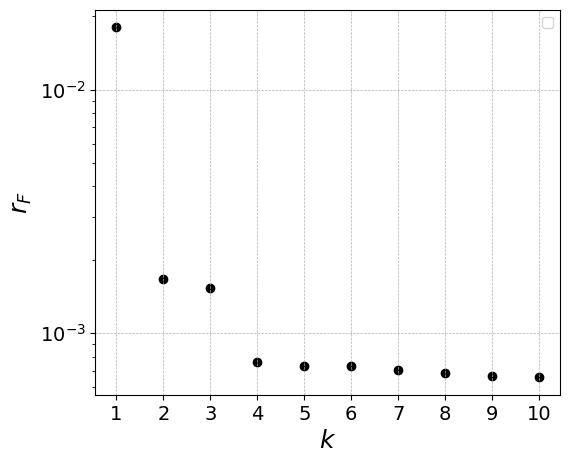

[0.018 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001]
(np.float64(1.0), np.float64(-0.9850369485672159))
[ρ · ρ[v_α], ∂β ρ · ∂β ρ[v_α], ρ[v_α], ρ[v_α] · ρ[v_β · v_β], ρ[v_α · v_β · v_β]]
ρ · ρ[v_α] + -0.985 · ρ[v_α] = 0


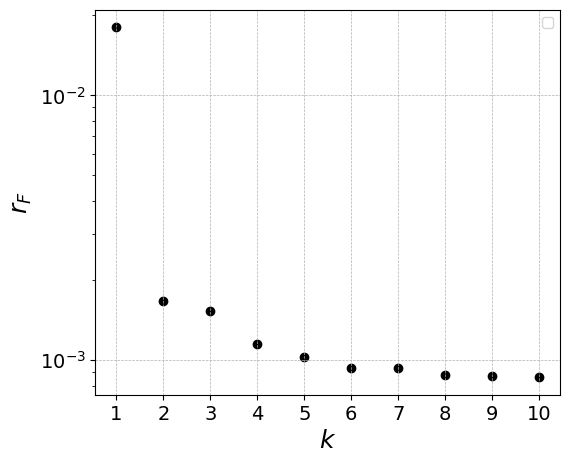

[0.013 0.009 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
(np.float64(1.0), np.float64(0.16943853558577004), np.float64(0.17149714017906878))
[ρ · ∂β ρ[v_α · v_β], ∂α ρ, ∂α ∂β² ρ, ∂t ρ[v_α], ∂β ρ[v_α · v_β]]
∂α ρ + 0.169 · ∂t ρ[v_α] + 0.171 · ∂β ρ[v_α · v_β] = 0


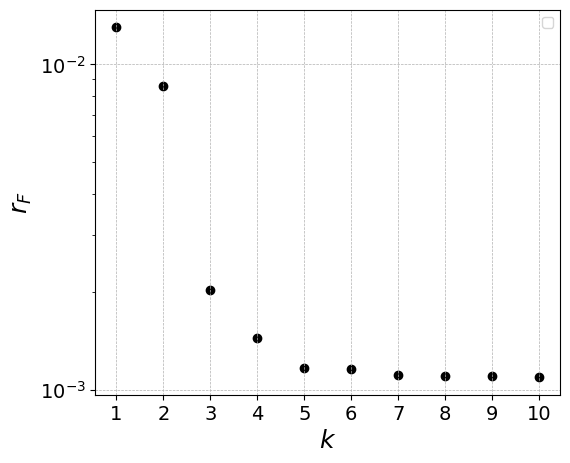

[0.029 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]
(np.float64(1.0), np.float64(-0.9884132357827723))
[ρ · ρ[v_α · v_β], ∂α ρ · ∂β ρ, ∂t ∂α ρ · ρ[v_β], ρ[v_α] · ρ[v_β], ρ[v_α · v_β]]
ρ · ρ[v_α · v_β] + -0.988 · ρ[v_α] · ρ[v_β] = 0


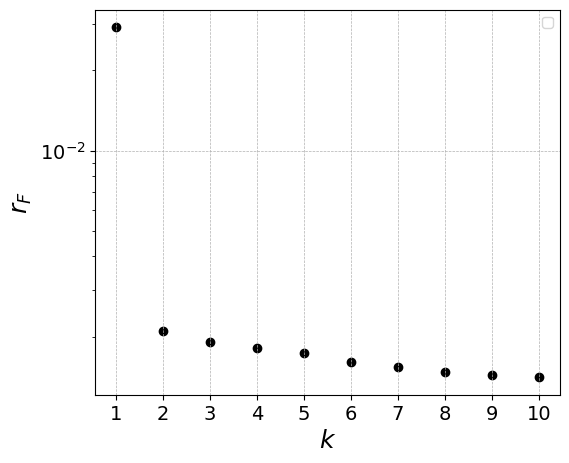

[0.018 0.01  0.008 0.004 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002]
(np.float64(1.0), np.float64(3.814987469539373e-05), np.float64(0.08061752004928993), np.float64(0.15828394030721094), np.float64(0.08234995977823104))
[∂α ∂β ρ, ∂α ∂β ∂γ² ρ, ∂t ∂α ρ[v_β], ∂α ∂β ρ[v_γ · v_γ], ∂γ² ρ[v_α · v_β]]
∂α ∂β ρ + 3.81e-05 · ∂α ∂β ∂γ² ρ + 0.0806 · ∂γ² ρ[v_α · v_β] + 0.158 · ∂t ∂α ρ[v_β] + 0.0823 · ∂α ∂β ρ[v_γ · v_γ] = 0


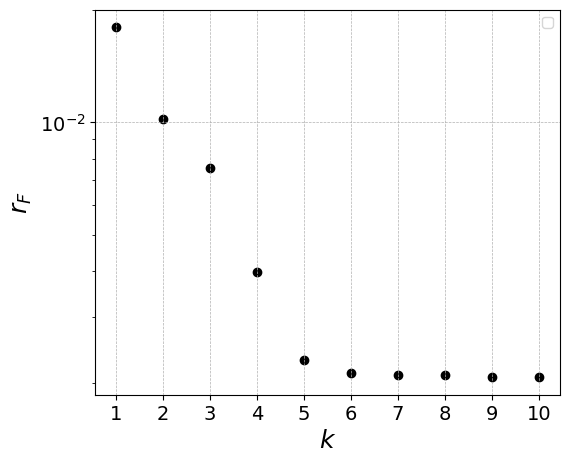

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for i, res in enumerate(reg_results):
    if len(eqs[i].terms)>1:
        all_lambdas = res.all_lambdas
        print(all_lambdas)
        all_xis = res.all_xis
        xi_values = res.xi
        sublibrary_terms = res.sublibrary
        equations = []
        print(eqs[i].coeffs)
        print([t for (t, c) in zip(res.sublibrary, res.all_xis[4]) if c!=0])
        #equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
        #equation_string = " + ".join(equation_terms)
        equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
        print(equation_string)
    
        
        plt.figure(figsize=(6, 5))
        #plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
        max_terms = min(10, len(all_lambdas))
        plt.scatter(range(1, max_terms+1), all_lambdas[:10], color='k')#, label="Lambda values")

        
        # Set log scale for y-axis
        plt.yscale("log")

        fs = 18
        fs2 = 14
        plt.xlabel("$k$", fontsize=fs)
        plt.ylabel("$r_F$", fontsize=fs)
        #plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
        #plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
        plt.xticks(range(1, max_terms+1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

        plt.yticks(fontsize=fs2)
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5) # which="both"

        name = f'discrete_pareto_{i}.eps'
        #plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300, 
        plt.show()

In [ ]:
1-0.99999995

5.000000002919336e-08

In [ ]:
for k, v in excluded_terms.items():
    print(len(v), v)

30 {ρ · ∂α² ρ, ρ · ∂t ρ[v_α · v_α], ∂t ρ · ∂α ρ[v_α], ρ · ∂α ρ[v_α], ∂t ∂α ρ[v_α], ρ · ρ · ρ · ρ · ρ, ∂α² ∂β² ρ, ρ · ρ, ρ · ∂t ρ · ∂t ρ, ρ · ρ · ρ · ρ, ρ · ρ · ∂t ρ, ρ · ∂t ∂α ρ[v_α], ρ · ρ[v_α · v_α], ∂α² ∂β ρ[v_β], ρ · ∂t² ρ, ρ · ρ[v_α] · ρ[v_α], ρ · ρ · ∂α² ρ, ρ · ρ · ∂α ρ[v_α], ρ · ρ · ρ · ∂t ρ, ρ · ∂α ρ · ρ[v_α], ρ · ρ · ρ, ∂α ρ[v_α], ∂t² ∂α ρ[v_α], ρ · ρ · ρ[v_α · v_α], ρ · ∂t³ ρ, ρ · ρ · ∂t² ρ, ρ · ∂t ∂α² ρ, ρ · ∂t ρ, ∂α ∂β ρ[v_α · v_β], ρ · ∂α ρ · ∂α ρ}
26 {∂α ∂β ρ[v_β], ρ · ∂t ρ[v_α], ρ · ∂α ∂β² ρ, ρ · ρ · ∂α ρ, ρ · ρ[v_α], ρ · ρ · ρ · ∂α ρ, ρ · ∂α ρ[v_β · v_β], ρ · ρ · ∂t ρ[v_α], ∂t ∂β ρ[v_α · v_β], ρ · ∂t² ρ[v_α], ρ · ∂α ρ · ∂t ρ, ρ · ∂t ρ · ρ[v_α], ∂β ρ[v_α · v_β], ρ · ρ · ρ[v_α], ρ · ∂t ∂α ρ, ρ · ∂β² ρ[v_α], ρ[v_α] · ∂β ρ[v_β], ∂α ρ · ∂β ρ[v_β], ρ · ρ · ρ · ρ[v_α], ρ · ∂β ρ[v_α · v_β], ρ · ∂α ρ, ρ · ∂t² ∂α ρ, ρ · ρ[v_α · v_β · v_β], ρ · ρ · ∂t ∂α ρ, ∂t ∂α ∂β ρ[v_β], ρ · ∂α ∂β ρ[v_β]}
12 {ρ · ∂α ρ · ρ[v_β], ρ · ρ · ρ[v_α · v_β], ρ · ∂t ∂α ρ[v_β], ρ · ∂α ρ[v_β], ρ · ∂t ∂α ∂β

In [ ]:
# from commons.identify_models import *
# import copy

# #srd = load('Q_gauss1024.npy', 1)
# libs = srd.libs

# reg_opts_list = []
# for irrep in srd.irreps:
#     #print(np.linalg.norm(libs[irrep].Q, axis=0))
#     # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
#     scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
#     #init = Initializer(method='combinatorial', start_k=3)
#     #init = Initializer(method='combinatorial', start_k=9999)
#     init = Initializer(method='power', start_k=10)
#     #res = Residual(residual_type='fixed_column', anchor_col=0)
#     #res = Residual(residual_type='dominant_balance')
#     res = Residual(residual_type='hybrid')
    
#     iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
#     #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
#     thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#     #thres = Threshold(threshold_type='information', ic=AIC)
    
#     opts = {'scaler': scaler, 'initializer': init, 'residual': res,
#             'model_iterator': iterator, 'threshold': thres}
#     opts['verbose'] = False
#     opts['inhomog'] = False
#     opts['inhomog_col'] = None
#     reg_opts_list.append(opts)

# eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
# #reg_opts_list, threshold=2e-2, experimental=True)
# reg_opts_list, threshold=4e-2, experimental=True)

In [ ]:
print(srd.scale_dict)
for irrep in srd.irreps:
    # don't forget preprocessing
    Q = srd.libs[irrep].Q/srd.libs[irrep].col_weights # reweight columns
    for i in range(Q.shape[0]): # normalize rows
        Q[i, :] /= np.linalg.norm(Q[i, :])
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'v': {'mean': np.float64(0.6939521606663382), 'std': np.float64(0.693952160666338)}, 'rho': {'mean': np.float64(1.0), 'std': np.float64(0.069783196803553)}}
1.391199355358483


1.4510527562981799
1.7668760635253615
1.652509145071676


In [ ]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib1.terms, r'∂α ∂β² ρ')))
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'∂β ρ\[v_α · v_β\]')))
print(next(regex_find(lib1.terms, r'∂α ρ\[v_β · v_β\]')))
print(next(regex_find(lib1.terms, r'∂α ρ')))

0 ρ · ∂α ρ 3.4891598401776496 3
1 ρ · ∂α ∂β² ρ 8722.899600444123 5
2 ρ · ∂t ∂α ρ 148.0511701022154 4
3 ρ · ∂t² ∂α ρ 6282.07074844674 5
4 ρ · ρ[v_α] 0.6939521606663382 3
5 ρ · ∂α ∂β ρ[v_β] 121.06550050007472 5
6 ρ · ∂β² ρ[v_α] 121.06550050007472 5
7 ρ · ∂t ρ[v_α] 2.0548085876322384 4
8 ρ · ∂t² ρ[v_α] 87.1891313868683 5
9 ρ · ∂β ρ[v_α · v_β] 1.6802733130835696 5
10 ρ · ∂α ρ[v_β · v_β] 1.6802733130835696 5
11 ρ · ρ[v_α · v_β · v_β] 0.334186265328837 5
12 ∂α ρ 3.4891598401776496 2
13 ∂β ρ · ∂α ∂β ρ 608.711819515426 5
14 ∂α ρ · ∂β² ρ 608.711819515426 5
15 ∂α ρ · ∂t ρ 10.331483940239197 4
16 ∂α ρ · ∂t² ρ 438.3829793727023 5
17 ∂α ρ · ∂β ρ[v_β] 8.448337647517357 5
18 ∂β ρ · ∂α ρ[v_β] 8.448337647517357 5
19 ∂β ρ · ∂β ρ[v_α] 8.448337647517357 5
20 ∂β ρ · ρ[v_α · v_β] 1.6802733130835708 5
21 ∂α ρ · ρ[v_β · v_β] 1.6802733130835708 5
22 ∂β² ρ · ρ[v_α] 121.06550050007478 5
23 ∂α ∂β ρ · ρ[v_β] 121.06550050007478 5
24 ∂α ∂β² ρ 8722.899600444123 4
25 ∂t ρ · ∂t ∂α ρ 438.3829793727024 5
26 ∂t ρ · ρ[v_α]

In [ ]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'ρ')))
print(next(regex_find(lib0.terms, r'ρ\[v_α · v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ρ')))
print(next(regex_find(lib0.terms, r'ρ · ρ\[v_α · v_α\]')))

0 ρ 1.0 1
1 ρ · ρ 1.0 2
2 ρ · ∂α² ρ 174.45799200888248 4
3 ρ · ∂t ρ 2.961023402044308 3
4 ρ · ∂t ∂α² ρ 7402.55850511077 5
5 ρ · ∂t² ρ 125.64141496893481 4
6 ρ · ∂t³ ρ 5331.185543652742 5
7 ρ · ∂α ρ[v_α] 2.4213100100014944 4
8 ρ · ∂t ∂α ρ[v_α] 102.7404293816119 5
9 ρ · ρ[v_α · v_α] 0.4815696012934793 4
10 ρ · ∂t ρ[v_α · v_α] 1.4259388591431381 5
11 ∂α ρ · ∂α ρ 12.17423639030852 4
12 ∂α ρ · ∂t ∂α ρ 516.5741970119598 5
13 ∂α ρ · ρ[v_α] 2.4213100100014953 4
14 ∂α ρ · ∂t ρ[v_α] 7.169555603218562 5
15 ∂α² ρ 174.45799200888248 3
16 ∂α² ρ · ∂t ρ 516.5741970119599 5
17 ∂α² ∂β² ρ 436144.9800222062 5
18 ∂t ρ 2.961023402044308 2
19 ∂t ρ · ∂t ρ 8.767659587454048 4
20 ∂t ρ · ∂t² ρ 372.027169988976 5
21 ∂t ρ · ∂α ρ[v_α] 7.169555603218564 5
22 ∂t ρ · ρ[v_α · v_α] 1.4259388591431392 5
23 ∂t ∂α ρ · ρ[v_α] 102.74042938161195 5
24 ∂t ∂α² ρ 7402.55850511077 4
25 ∂t² ρ 125.64141496893481 3
26 ∂t² ∂α² ρ 314103.53742233705 5
27 ∂t³ ρ 5331.185543652742 4
28 ∂t⁴ ρ 226211.5506091625 5
29 ρ[v_α] · ρ[v_α] 0.481569

In [ ]:
col_norms = np.linalg.norm(lib0.Q/lib0.col_weights, axis=0)
print(len(col_norms), lib0.Q.shape)
for term, norm in zip(lib0.terms, col_norms/max(col_norms)):
    print(term, norm)

42 (240, 42)
ρ 0.05249446768407049
ρ · ρ 0.05340107500830318
ρ · ∂α² ρ 0.018575209139585123
ρ · ∂t ρ 0.06282884266679613
ρ · ∂t ∂α² ρ 0.028792856109265713
ρ · ∂t² ρ 0.09136317630874151
ρ · ∂t³ ρ 0.2624348612613702
ρ · ∂α ρ[v_α] 0.07683347508798144
ρ · ∂t ∂α ρ[v_α] 0.11172815929663192
ρ · ρ[v_α · v_α] 0.13064064384731022
ρ · ∂t ρ[v_α · v_α] 0.39195998627684603
∂α ρ · ∂α ρ 0.0340724896609743
∂α ρ · ∂t ∂α ρ 0.021270598642578437
∂α ρ · ρ[v_α] 0.0381130398011723
∂α ρ · ∂t ρ[v_α] 0.2139361496987827
∂α² ρ 0.01839941929925559
∂α² ρ · ∂t ρ 0.026391759932254486
∂α² ∂β² ρ 0.02052077493876934
∂t ρ 0.06110310150900789
∂t ρ · ∂t ρ 0.14109751525572228
∂t ρ · ∂t² ρ 0.13492127610804217
∂t ρ · ∂α ρ[v_α] 0.17254830726654988
∂t ρ · ρ[v_α · v_α] 0.14605032348946456
∂t ∂α ρ · ρ[v_α] 0.042200982857277726
∂t ∂α² ρ 0.028808621392349507
∂t² ρ 0.09046280427144231
∂t² ∂α² ρ 0.10199347244958656
∂t³ ρ 0.2547143385795447
∂t⁴ ρ 1.0
ρ[v_α] · ρ[v_α] 0.11583221555212217
ρ[v_α] · ∂t ρ[v_α] 0.20044223106528758
∂α ρ[v_α] 0

In [ ]:
# test specific relation for r_h: dt rho[v_alpha], d_alpha rho
lt = lib1.terms
#print(f'{lt[12]}, {lt[39]}')
#scaler = Scaler(sub_inds=[12, 39], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
print(f'{lt[33]}, {lt[48]}')
scaler = Scaler(sub_inds=[33, 48], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

ρ[v_α], ρ[v_α · v_β · v_β]
0.14022495894447026 [ 1.    -0.552]


In [ ]:
lt = lib0.terms
print(f'{lt[15]}, {lt[25]}')
scaler = Scaler(sub_inds=[15, 25], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α² ρ, ∂t² ρ
0.12345157419547312 [ 1.    -0.243]


In [ ]:
np.linalg.norm(lib1.Q[:, 12]), lib1.col_weights[12]

(np.float64(7653.010504968555), np.float64(3.4891598401776496))

In [ ]:
# test specific relation for r_h: rho, rho[v_alpha * v_alpha]
scaler = Scaler(sub_inds=[0, 35], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

0.22076410886939682 [ 1.    -0.721]


In [ ]:
# ostrichified
scaler = Scaler(sub_inds=[0, 35, 1, 9], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh = hybrid_residual(lib0.Q, None, scaler)
print(rh)

0.014485861302546357


In [ ]:
#(24, ∂α ∂β² ρ)
#(39, ∂t ρ[v_α])
#(45, ∂β ρ[v_α · v_β])
#(44, ∂α ρ[v_β · v_β])
#(12, ∂α ρ)
lt = lib1.terms
print(f'{lt[12]}, {lt[24]}, {lt[39]}, {lt[45]}')
scaler = Scaler(sub_inds=[12, 24, 39, 45], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α ρ, ∂α ∂β² ρ, ∂t ρ[v_α], ∂β ρ[v_α · v_β]
0.010072455476412669 [1.000e+00 3.985e-05 1.573e-01 1.590e-01]


In [ ]:
scaler = Scaler(sub_inds=[24, 39, 44, 45], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh = hybrid_residual(lib1.Q, None, scaler)
print(rh)

0.07427271294804302


In [ ]:
lib0 = libs[srd.irreps[0]]
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(libs0.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
#opts['inhomog_col'] = 1 # ρ²
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib0.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

∂α² ρ + 3.399156723753489e-05 · ∂α² ∂β² ρ + -0.16104509749286708 · ∂t² ρ + 0.16882644738824726 · ∂α ∂β ρ[v_α · v_β] = 0 ; residual: 0.0013864651293323082
(r_h = 1.36e-02)


In [ ]:
lib1 = libs[srd.irreps[1]]
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(lib1.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 39 # dt rho[v_i]
opts['verbose'] = False

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib1.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

ρ · ∂α ρ + 3.894952822225569e-05 · ρ · ∂α ∂β² ρ + 0.16320027432968653 · ∂t ρ[v_α] + 0.15949377750778063 · ∂β ρ[v_α · v_β] = 0 ; residual: 0.0009285750820378927
(r_h = 6.76e-03)
